In [1]:

# ONLY RUN THIS CELL IF YOU NEED 
# TO DOWNLOAD NLTK AND HAVE CONDA

# Uncomment the code below and run:


# !conda install nltk #This installs nltk
# import nltk # Imports the library
# nltk.download() #Download the necessary datasetsnltk

Fetching package metadata .......
Solving package specifications: ..........

# All requested packages already installed.
# packages in environment at /home/jlee/anaconda2:
#
nltk                      3.2.1                    py27_0  


#### NLP (Natural Language Processing)
This is the notebook that goes along with the NLP video lecture!
In this lecture we will discuss a higher level overview of the basics of Natural Language Processing, which basically consists of combining machine learning techniques with text, and using math and statistics to get that text in a format that the machine learning algorithms can understand!  
In this lecture we will go over:  
* Part 1: Data
* Part 2: Basic Exploratory Data Analysis
* Part 3: Text Pre-Processing
* Part 4: Vectorization
* Part 6: Model Evaluation
* Part 7: Creating a Data Pipeline  
Requirements: You will need to have NLTK installed, along with downloading the corpus for stopwords. To download everything with a conda installation, run the cell below:

In [2]:
import nltk

#### Part 1: Data
We'll be using a dataset from the UCI datasets! Go to   https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection and download the zip file. Unzip it in the same place as whatever notebook your working in. (Type pwd into code cell to find out where you working directory is). Or just make sure to know the exact path to the data so you can put into your code later on.  
The file we are using contains a collection of more than 5 thousand SMS phone messages. You can check out the readme file for more info.  
Let's go ahead and use rstrip() plus a list comprehension to get a list of all the lines of text messages:  

In [5]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
print len(messages)

5574


In [8]:
for num, message in enumerate(messages[:10]):
    print num,message
    print '\n'

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code 

#### unsupervised learning diagram

In [11]:
import pandas
messages = pandas.read_csv('smsspamcollection/SMSSpamCollection', 
                           sep='\t',names=['labels', 'message'])

In [12]:
messages.head()

,labels,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
messages.describe()

,labels,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [16]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
labels     5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [17]:
messages.groupby('labels').describe()

message
labels                                                          
ham    count                                                4825
       unique                                               4516
       top                                Sorry, I'll call later
       freq                                                   30
spam   count                                                 747
       unique                                                653
       top     Please call our customer service representativ...
       freq                                                    4

#### read [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering) 
###

In [18]:
messages['length'] = messages['message'].apply(len)
messages.head()

,labels,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

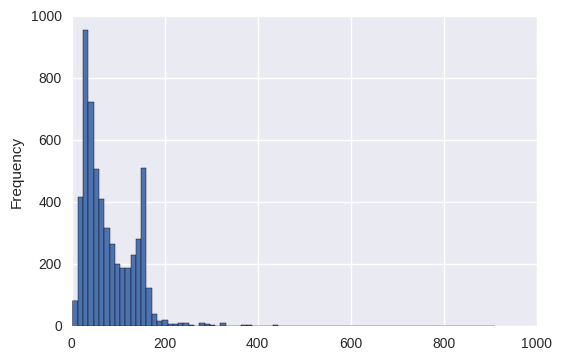

In [25]:
messages['length'].plot(bins=80, kind='hist')

In [26]:
messages['length'].describe()

count    5572.000000
mean       80.616296
std        60.015593
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [31]:
messages[messages['length'] == 910]#['message'].iloc[0]

,labels,message,length
1085,ham,For me the love should start with attraction.i...,910


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f78c0bc0950>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f78c0b1e2d0>], dtype=object)

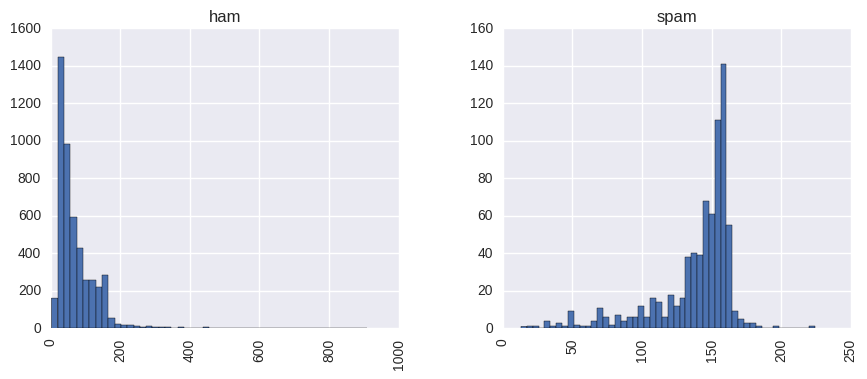

In [32]:
messages.hist(column='length',by='labels',bins=50, figsize=(10,4))

Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters. (Sorry Romeo!)  
Now let's begin to process the data so we can eventually use it with SciKit Learn!  
#### Part 3: Text pre-processing
Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.  
We'll begin by  
In this section we'll massage the raw messages (sequence of characters) into vectors (sequences of numbers).  
As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.  
Let's create a function that will process the string in the message column, then we can just use apply() in pandas do process all the text in the DataFrame.  
First removing punctuation. We can just take advantage of Python's built-in string library to get a quick list of all the possible punctuation:  

In [33]:
import string

In [34]:
mess = 'Sample message! Notice: it has punctuation'

In [35]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [37]:
nopunc = [char for char in mess if char not in string.punctuation]

In [38]:
print nopunc

['S', 'a', 'm', 'p', 'l', 'e', ' ', 'm', 'e', 's', 's', 'a', 'g', 'e', ' ', 'N', 'o', 't', 'i', 'c', 'e', ' ', 'i', 't', ' ', 'h', 'a', 's', ' ', 'p', 'u', 'n', 'c', 't', 'u', 'a', 't', 'i', 'o', 'n']


In [39]:
nopunc = ''.join(nopunc)

In [40]:
nopunc

'Sample message Notice it has punctuation'

In [42]:
from nltk.corpus import stopwords

In [46]:
stopwords.words('english')[0:10]

[u'i',
 u'me',
 u'my',
 u'myself',
 u'we',
 u'our',
 u'ours',
 u'ourselves',
 u'you',
 u'your']

In [47]:
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [48]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

In [49]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [50]:
messages.head()

,labels,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [51]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [53]:
messages.head(5)

,labels,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


#### Continuing Normalization
There are a lot of ways to continue normalizing this text. Such as Stemming or distinguishing by part of speech.
NLTK has lots of built-in tools and great documentation on a lot of these methods. Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand, For example:
'Nah dawg, IDK! Wut time u headin to da club?'

versus
'No dog, I don't know! What time are you heading to the club?'

Some text normalization methods will have trouble with this type of shorthand and so I'll leave you to explore those more advanced methods through the NLTK book online.
For now we will just focus on using what we have to convert our list of words to an actual vector that SciKit-Learn can use.  

#### Part 4: Vectorization  
Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.
Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.  
We'll do that in three steps using the bag-of-words model:  
1. Count how many times does a word occur in each message **(Known as term frequency)**  
2. Weigh the counts, so that frequent tokens get lower weight **(inverse document frequency)**
3. Normalize the vectors to unit length, to abstract from the original text length **(L2 norm)**

Let's begin the first step:  
Each vector will have as many dimensions as there are unique words in the SMS corpus. We will first use SciKit Learn's CountVectorizer. This model will convert a collection of text documents to a matrix of token counts.  
We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.  
* For example: *  

|Message 1|	Message 2	|...	|Message N  
---------|------------|-------|---------
Word 1 Count|	0	|1	|...	|0  
Word 2 Count|	0	|0	|...	|0  
...|	1	|2	|...	|0  
Word N Count|	0	|1	|...	|1   
Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a Sparse Matrix.    

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

In [55]:
bow_transformer = CountVectorizer(analyzer=text_process)

In [56]:
bow_transformer.fit(messages['message'])

/home/jlee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


CountVectorizer(analyzer=<function text_process at 0x7f78c0a72758>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None,
        vocabulary=None)

In [57]:
message4 = messages['message'][3]

In [58]:
print message4

U dun say so early hor... U c already then say...


In [60]:
bow4 = bow_transformer.transform([message4])

In [61]:
print bow4

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


In [69]:
print bow_transformer.get_feature_names()[9570]

schedule


In [65]:
messages_bow = bow_transformer.transform(messages['message'])

/home/jlee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [74]:
print 'Shape of Sparse Matrix: ', messages_bow.shape
print 'Amount of Non-Zero occurence: ', messages_bow.nnz
print 'Sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurence:  50548
Sparsity: 0.08%


After the counting, the term weighting and normalization can be done with TF-IDF, using scikit-learn's TfidfTransformer.  

#### So what is TF-IDF?  
TF-IDF stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.
One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.  

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.  

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:    
*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)*.

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:
*IDF(t) = log_e(Total number of documents / Number of documents with term t in it)*.

See below for a simple example.

#### Example:

Consider a document containing 100 words wherein the word cat appears 3 times.
The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

In [77]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [79]:
tfidf4 = tfidf_transformer.transform(bow4)

In [80]:
print tfidf4

  (0, 9554)	0.538562626293
  (0, 7186)	0.438936565338
  (0, 6222)	0.318721689295
  (0, 6204)	0.299537997237
  (0, 5261)	0.297299574059
  (0, 4629)	0.266198019061
  (0, 4068)	0.408325899334


In [81]:
print tfidf_transformer.idf_[bow_transformer.vocabulary_['u']]

3.28005242674


In [84]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

In [85]:
print messages_tfidf.shape

(5572, 11425)


There are many ways the data can be preprocessed and vectorized. These steps involve feature engineering and building a "pipeline". I encourage you to check out SciKit learn's documentation on dealing with text data as well as the expansive collection of availble papers and books on the general topic of NLP.  

#### Part 5: Training a model
With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a variety of reasons, the Naive Bayes classifier algorithm is a good choice.  
We'll be using scikit-learn here, choosing the Naive Bayes classifier to start with: